# Churn prediction

 Predict whether a customer will churn (cancel) their subscription to a service based on their usage patterns, demographics, and other features? Use the Telco Customer Churn dataset, which contains information on customers of a telecommunications company and their associated churn status, and apply any suitable method to predict whether a customer is likely to churn or not.

## The libraries

Import the necessary libraries

In [2]:
import numpy as np # 
import pandas as pd # data processing
import seaborn as sns # for plots
import matplotlib.pyplot as plt # for plots
from sklearn import metrics #for the accuracy
sns.set(style = 'white')

## The dataset

### Overview

In [3]:
df = pd.read_csv('C:/Users/Mulle/Desktop/AI-mini-project/Churn/Telco_customer_churn.csv')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
df.columns.values

array(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score',
       'CLTV', 'Churn Reason'], dtype=object)

In [5]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


### Data cleanning 

#### Outliers detection

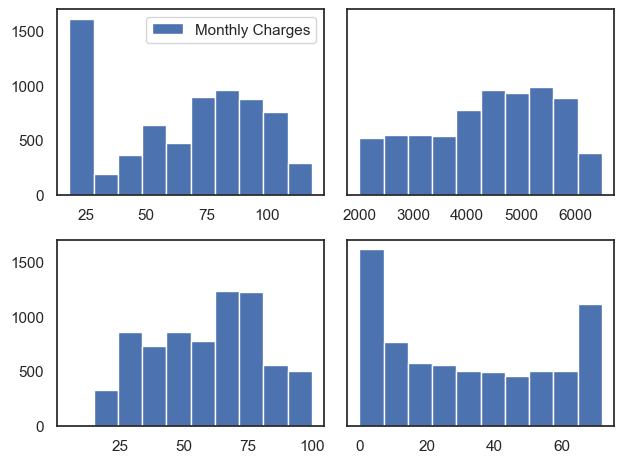

In [6]:
N_points = 100000
n_bins = 10

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
#axs[0].hist(df, bins=n_bins)
outliers_columns = ['Monthly Charges', 'CLTV', 'Churn Score', ]
axs[0,0].hist(df['Monthly Charges'], bins=n_bins, label = 'Monthly Charges')
axs[0,1].hist(df['CLTV'], bins=n_bins)
axs[1,0].hist(df['Churn Score'], bins=n_bins)
axs[1,1].hist(df['Tenure Months'], bins=n_bins)
axs[0,0].legend()

Statistical method

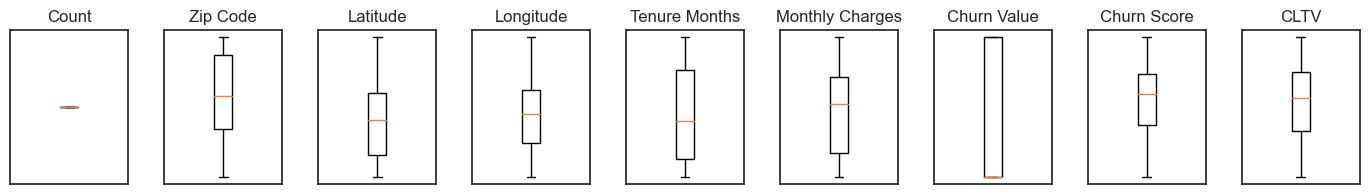

In [7]:
nb_columns = len(df.select_dtypes(include=["int64", "float64"]).columns)
fig, axs = plt.subplots(1, nb_columns, figsize=(15,2))

for i in range(nb_columns):
        column_name = df.select_dtypes(include=["int64", "float64"]).columns[i]
        axs[i].boxplot(df[column_name], 0, 'gD')
        axs[i].set_title(column_name)
        axs[i].set_xticks(()) #removes the graduation on x
        axs[i].set_yticks(()) #removes the graduation on x
fig.subplots_adjust(left=0.08, right=0.98, hspace=0.4, wspace=0.3)

In [8]:
#Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers.
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

for elements in df.select_dtypes(include=["int64", "float64"]).columns.values:
   outliers = find_outliers_IQR(df[elements])
   print("\n" + elements)
   print("number of outliers:" + str(len(outliers)))
   print("max outlier value:" + str(outliers.max()))
   print("min outlier value:" + str(outliers.min()))
   outliers


Count
number of outliers:0
max outlier value:nan
min outlier value:nan

Zip Code
number of outliers:0
max outlier value:nan
min outlier value:nan

Latitude
number of outliers:0
max outlier value:nan
min outlier value:nan

Longitude
number of outliers:0
max outlier value:nan
min outlier value:nan

Tenure Months
number of outliers:0
max outlier value:nan
min outlier value:nan

Monthly Charges
number of outliers:0
max outlier value:nan
min outlier value:nan

Churn Value
number of outliers:0
max outlier value:nan
min outlier value:nan

Churn Score
number of outliers:0
max outlier value:nan
min outlier value:nan

CLTV
number of outliers:0
max outlier value:nan
min outlier value:nan


Get rid of outliers (not necessary in our case)

In [9]:
def drop_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   outliers_dropped = outliers.dropna().reset_index()
   return outliers_dropped

#### Check for wrong data types

In [10]:
df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

In [11]:
df["Zip Code"] = df["Zip Code"].astype(str)

#### Imputation

Checking for missing values

In [12]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

We can see we have 5174 null values in the 'Churn reason' column, let's check if they all are because the custumer didn't churn :

In [13]:
df["Churn Reason"].isnull()[df["Churn Value"] == 1].unique()

array([False])

All the missing values in the churn reason match custumers that didn't churn

#### Feature Engineering

Feature transformation

In [14]:
df_clean = df.drop(columns = ['Churn Label', 'CustomerID'])
#df_clean = df.drop(columns = ['Count', 'Country', 'Churn Reason', 'State', 'City', 'Latitude', 'Longitude', 'Lat Long',
#                                'Total Charges', 'Contract', 'Payment Method', 'Zip Code'])

df_clean['Churn Value'].replace(to_replace='Yes', value=1, inplace=True)
df_clean['Churn Value'].replace(to_replace='No',  value=0, inplace=True)

df_clean


,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Churn Reason
0,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239,Competitor made better offer
1,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701,Moved
2,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,...,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1,86,5372,Moved
3,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,...,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84,5003,Moved
4,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,...,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,No,...,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.4,0,45,5306,NaN
7039,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,No,...,Yes,One year,Yes,Mailed check,84.80,1990.5,0,59,2140,NaN
7040,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,No,...,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,0,71,5560,NaN
7041,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,No,...,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,59,2793,NaN


One-hot encoding

In [15]:
df_dummies = pd.get_dummies(df_clean)
df_dummies.head()

,Count,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV,Country_United States,State_California,...,Churn Reason_Lack of self-service on Website,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction
0,1,33.964131,-118.272783,2,53.85,1,86,3239,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,34.059281,-118.307420,2,70.70,1,67,2701,True,True,...,False,False,False,True,False,False,False,False,False,False
2,1,34.048013,-118.293953,8,99.65,1,86,5372,True,True,...,False,False,False,True,False,False,False,False,False,False
3,1,34.062125,-118.315709,28,104.80,1,84,5003,True,True,...,False,False,False,True,False,False,False,False,False,False
4,1,34.039224,-118.266293,49,103.70,1,89,5340,True,True,...,False,False,False,False,False,False,False,False,False,False


### Feature selection

#### Feature selection with rf

In [16]:
from sklearn.model_selection import train_test_split
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

X = df_dummies.drop(columns="Churn Value")
y = df_dummies["Churn Value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, random_state=42)

#Train and predict)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

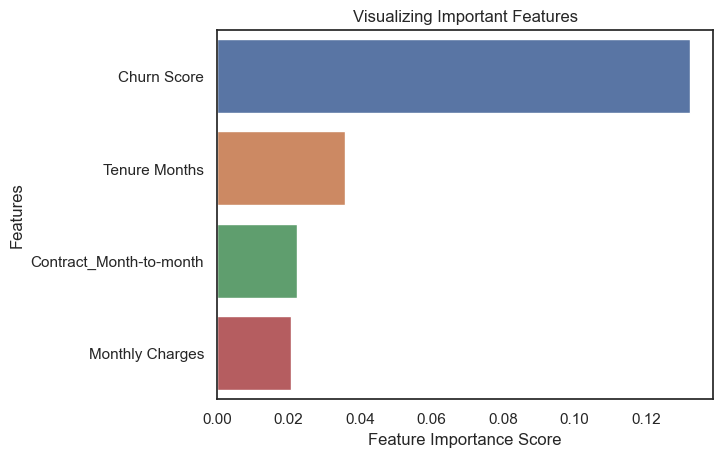

In [17]:

feature_imp = pd.Series(clf.feature_importances_,index=X.columns.values).sort_values(ascending=False)
# Creating a bar plot
sns.barplot(x=feature_imp[:4], y=feature_imp.index[:4])

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#### Correlation between Churn and the other variables

In [18]:
plt.figure(figsize=(10,5))
#data = df_dummies.corr()['Churn Value'].drop(index="Churn Value").sort_values(ascending = False)[1:18].plot(kind='bar')
#Complete correlation between two variables is expressed by either + 1 or -1
#very long to load because of the number of columns in dummies

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

## Testing different models

### Creating the dataset

#### Preparing the trainning and testing dataset that we will use to train and test the different models

In [19]:
# We will use the data frame where we had created dummy variables
y = df_dummies['Churn Value'].values
X = df_dummies.drop(columns = ['Churn Value'])

Test and train sets with not scaled data

In [20]:
from sklearn.model_selection import train_test_split

# Create Train & Test Data
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y, test_size=0.3, random_state=101)

Scaling the data

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Scaling all the variables to a range of 0 to 1
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))
X_scaled.columns = features

# Create Train & Test Data scaled
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101)

### Logistic regression

#### Training and testing the model with scaled data

In [22]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

c:\Users\Mulle\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
prediction_test = model_lr.predict(X_test)

# Print the prediction accuracy
accuracy_lr = metrics.accuracy_score(y_test, prediction_test)
accuracy_lr

0.9966871746332229

<Axes: >

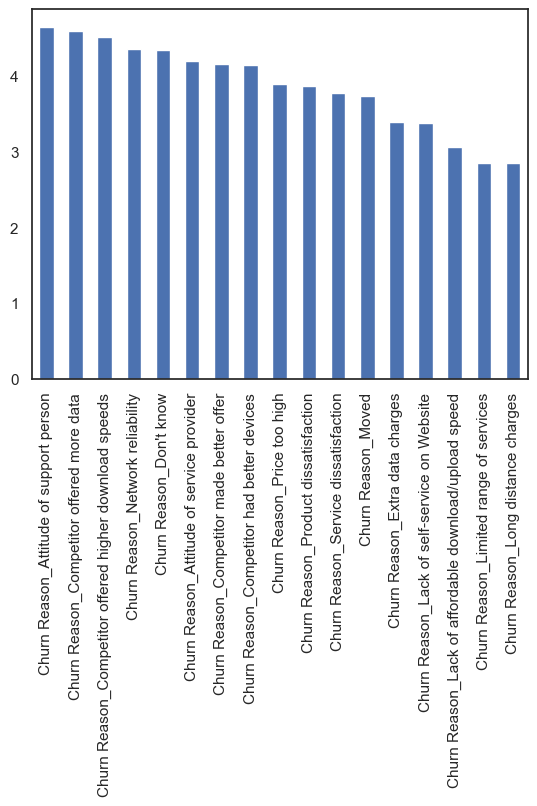

In [24]:
# To get the weights of all the variables
weights = pd.Series(model_lr.coef_[0],
                 index=X.columns.values)
weights.sort_values(ascending = False)[1:18].plot(kind='bar')

<Axes: >

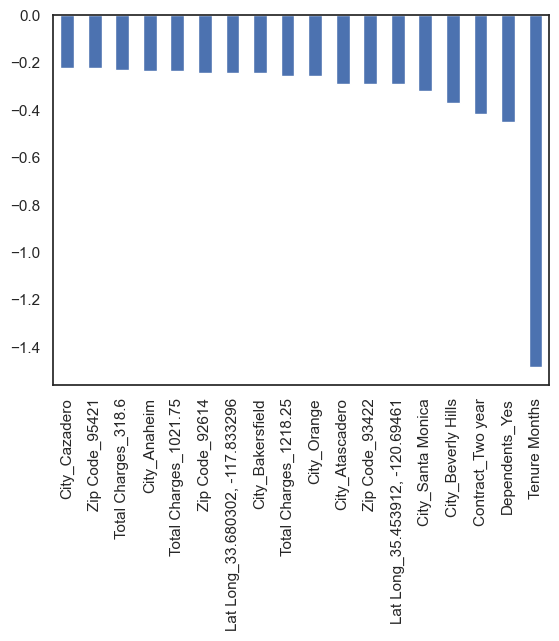

In [25]:
weights.sort_values(ascending = False)[-18:].plot(kind='bar')

#### Compare the accuracy of the scaled data model and the one trained with not scaled data

In [26]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression

model_lr_ns = LogisticRegression()
model_lr_ns.fit(X_train_ns, y_train_ns)

c:\Users\Mulle\anaconda3\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
from sklearn import metrics
prediction_test_ns = model_lr_ns.predict(X_test_ns)
# Print the prediction accuracy
accuracy_lr_ns = metrics.accuracy_score(y_test_ns, prediction_test_ns)
accuracy_lr_ns

0.9119734973970658

In [28]:
print("Accuracy difference")
abs(accuracy_lr_ns-accuracy_lr)

Accuracy difference


0.08471367723615708

### Random forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators= 500 , oob_score = True, n_jobs = 1,
                                  random_state =50, max_features = "sqrt",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train) #train model

RandomForestClassifier(max_leaf_nodes=30, n_estimators=500, n_jobs=1,
                       oob_score=True, random_state=50)

In [52]:
# Make predictions
prediction_test = model_rf.predict(X_test)
accuracy_rf = metrics.accuracy_score(y_test, prediction_test)
accuracy_rf

0.8045433033601515

Test with not scaled data

In [ ]:
model_rf.fit(X_train_ns, y_train_ns) #train model
# Make predictions
prediction_test_ns = model_rf.predict(X_test_ns)
accuracy_rf_ns = metrics.accuracy_score(y_test_ns, prediction_test)
accuracy_rf_ns

0.9247515380974917

Not scaled affects the time of computing

<Axes: >

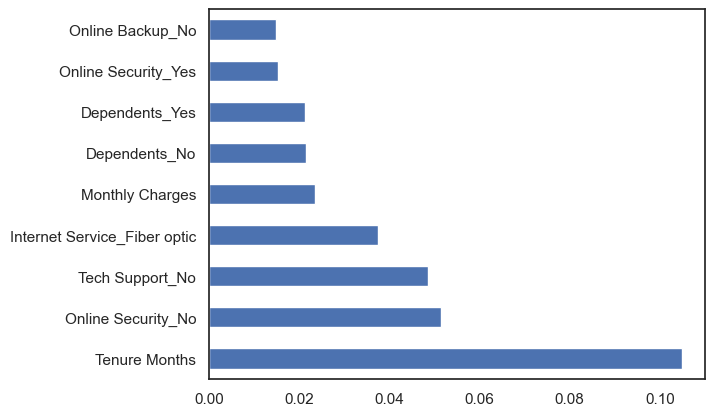

In [ ]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values(ascending=False)[1:10].plot(kind = 'barh')

### Vector support machine

In [ ]:
from sklearn.svm import SVC
kernels = ['rbf', 'poly', 'linear']

for kernel in kernels:
    model_vsm = SVC(kernel=kernel)
    model_vsm.fit(X_train, y_train) #trains the model
    pred_vsm = model_vsm.predict(X_test) #does prediction
    print("Accuracy using {}:".format(kernel), metrics.accuracy_score(pred, y_test))

Accuracy using rbf: 0.9081874112636062
Accuracy using poly: 0.9162328442972077
Accuracy using linear: 0.9200189304306673


In [ ]:
model_vsm_ns = SVC(kernel="linear")
model_vsm_ns.fit(X_train_ns, y_train_ns) #trains the model
pred_vsm_ns = model_vsm_ns.predict(X_test_ns) #does prediction
print("Accuracy using linear"), metrics.accuracy_score(pred, y_test_ns)

Accuracy using linear


(None, 0.9181258873639375)

Not scaled affects the time of computing and the accuracy

In [ ]:
# Create the Confusion matrix for linear kernel
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, pred_vsm)) 

NameError: name 'pred_vsm' is not defined

c:\Users\Mulle\anaconda3\envs\py38\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


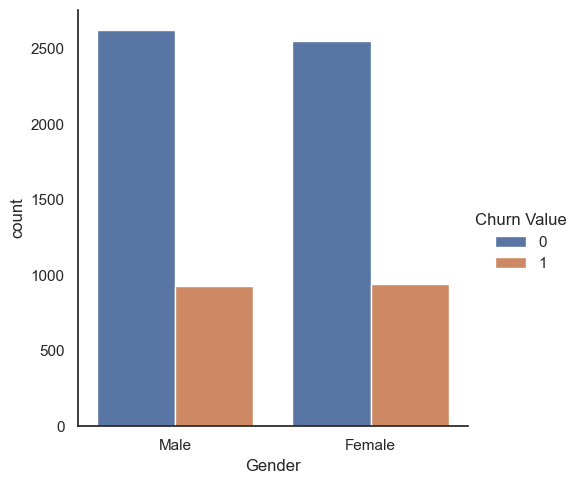

In [ ]:
ax1 = sns.catplot(x="Gender", kind="count", hue="Churn Value", data=df,
                  estimator=lambda x: sum(x==0)*100.0/len(x))
#ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

## Compare accuraccy of the different models